In [95]:
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import statsmodels.api as sm

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, acf
from statsmodels.graphics.tsaplots import plot_pacf, pacf
import holidays
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import prophet
warnings.filterwarnings('ignore')

# Loading the data
- It works best with time series that have strong seasonal effects and several seasons of historical data.
- It is robust to missing data and shifts in the trend, and typically handles outliers well.
- It handles unevenly distributed time intervals.
- Prophet’s default settings to produce forecasts that are often accurate as those produced by skilled forecasters, with much less effort.

so i feel like we don't need to make our regions stationary

In [153]:
### 4 regions
east=pd.read_csv('final data/east_daily.csv', index_col=0, parse_dates=[0])
print(east.shape)
east.tail()

(1136, 1)


,daily_deaths
date,
2023-03-19,0
2023-03-20,7
2023-03-21,14
2023-03-22,266
2023-03-23,80


In [154]:
midwest=pd.read_csv('final data/midwest_stationary.csv', index_col=0, parse_dates=[0])
print(midwest.shape)
midwest.tail()

(1136, 1)


,daily_deaths
date,
2023-03-19,0.0
2023-03-20,23.0
2023-03-21,108.0
2023-03-22,-91.0
2023-03-23,192.0


In [172]:
south=pd.read_csv('final data/south_daily.csv', index_col=0, parse_dates=[0])
print(south.shape)
south.tail()

(1136, 1)


,daily_deaths
date,
2023-03-19,0
2023-03-20,71
2023-03-21,31
2023-03-22,240
2023-03-23,58


In [156]:
west=pd.read_csv('final data/west_stationary.csv', index_col=0, parse_dates=[0])
print(east.shape)
west.tail()

(1136, 1)


,daily_deaths
date,
2023-03-19,0.0
2023-03-20,37.0
2023-03-21,-4.0
2023-03-22,151.0
2023-03-23,-95.0


# Visualizing the Data

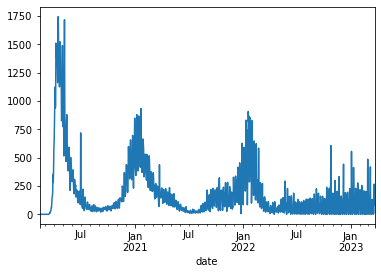

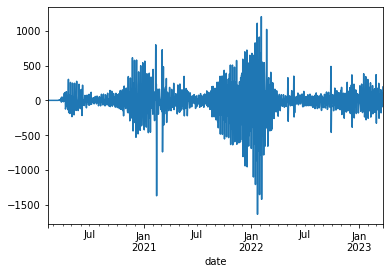

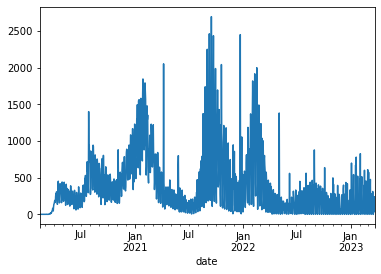

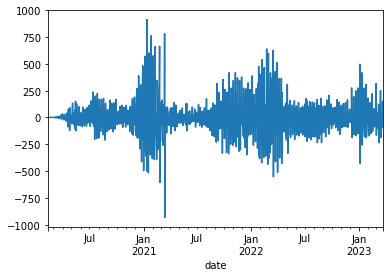

In [6]:
east['daily_deaths'].plot()
plt.show()

midwest['daily_deaths'].plot()
plt.show()

south['daily_deaths'].plot()
plt.show()

west['daily_deaths'].plot()
plt.show()

# splitting into train test
- setting a specific number for train test i.e. train is any data before 2023 and test is the last couple of months

In [173]:
easttrain = east[east.index < '2023-01-01']
easttest = east[east.index >= '2023-01-01']
print(easttrain.shape, easttest.shape)

midwesttrain = midwest[midwest.index < '2023-01-01']
midwesttest = midwest[midwest.index >= '2023-01-01']
print(midwesttrain.shape, midwesttest.shape)

southtrain = south[south.index < '2023-01-01']
southtest = south[south.index >= '2023-01-01']
print(southtrain.shape, southtest.shape)

westtrain = west[west.index < '2023-01-01']
westtest = west[west.index >= '2023-01-01']
print(westtrain.shape, westtest.shape)

(1054, 1) (82, 1)
(1054, 1) (82, 1)
(1054, 1) (82, 1)
(1054, 1) (82, 1)


# Visualizing data again

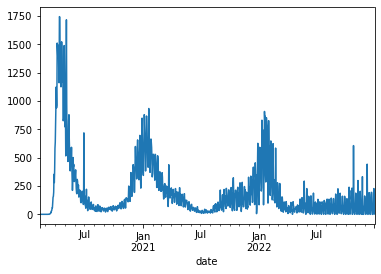

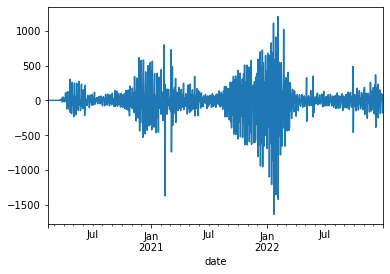

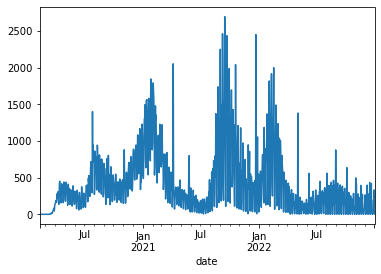

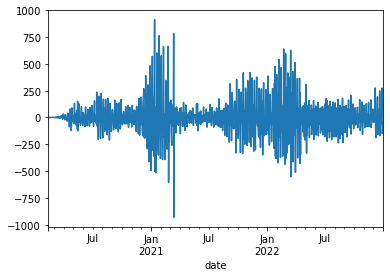

In [8]:
easttrain['daily_deaths'].plot()
plt.show()

midwesttrain['daily_deaths'].plot()
plt.show()

southtrain['daily_deaths'].plot()
plt.show()

westtrain['daily_deaths'].plot()
plt.show()

# Building the prophet model

### defining an MASE function

In [101]:
def MASE(Actual, Predicted):
    n = len(Actual)
    
    mae = mean_absolute_error(Actual, Predicted)

    # Calculate the denominator
    denominator = 1 / (n - 1) * np.sum(np.abs(Predicted[1:] - Actual[:-1]))

    # Avoid division by zero or small denominators
    if denominator > 1e-6:
        mase = mae / denominator
    else:
        mase = np.inf

    return mase

## east

INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


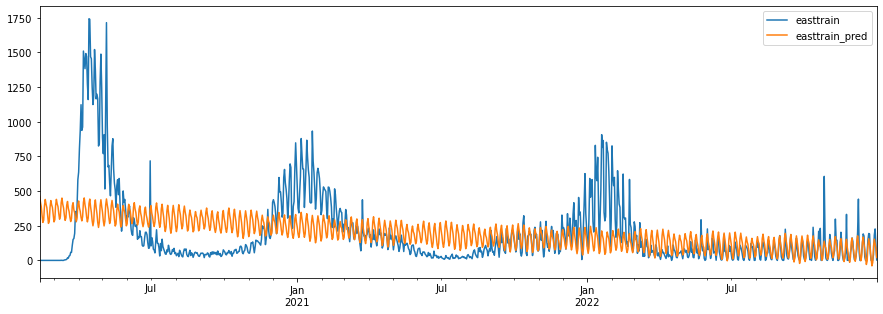

Training Set Metrics:
MAE: 155.80563184235245
MASE: 0.9594877888996809


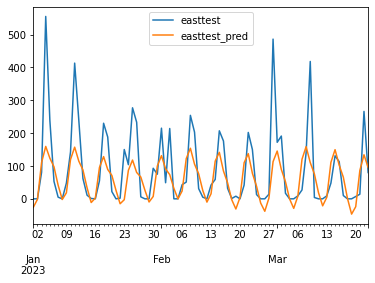

Testing Set Metrics:
MAE: 60.65951966531297
MASE: 0.7786441138994341


In [159]:
# CURRENT BEST
emodel = prophet.Prophet(
    changepoint_prior_scale=0.04, # controls flexibility of trend
    seasonality_prior_scale=7.0, # controls strength of seasonality components
    yearly_seasonality=False,  # Disable default yearly seasonality
)
emodel.add_seasonality(name='monthly', period=30.44, fourier_order=5)
emodel.add_seasonality(name='weekly', period=7, fourier_order=3)

emodel.fit(easttrain.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'}))

# train
easttrain_pred=emodel.predict(easttrain.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'})).set_index('ds')

pd.concat([easttrain,easttrain_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['easttrain', 'easttrain_pred'])
plt.show()

# Calculate metrics

actual_train = easttrain['daily_deaths'].values
predicted_train = easttrain_pred['yhat'].values

mae_train = mean_absolute_error(actual_train, predicted_train)
mase_train = MASE(actual_train, predicted_train)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

#test

easttest_pred=emodel.predict(easttest.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'})).set_index('ds')

pd.concat([easttest,easttest_pred['yhat']], axis=1).plot( )
plt.legend(['easttest', 'easttest_pred'])
plt.show()

# Calculate metrics

actual_test = easttest['daily_deaths'].values
predicted_test = easttest_pred['yhat'].values

mae_test = mean_absolute_error(actual_test, predicted_test)
mase_test = MASE(actual_test, predicted_test)
print("Testing Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

## midwest

INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


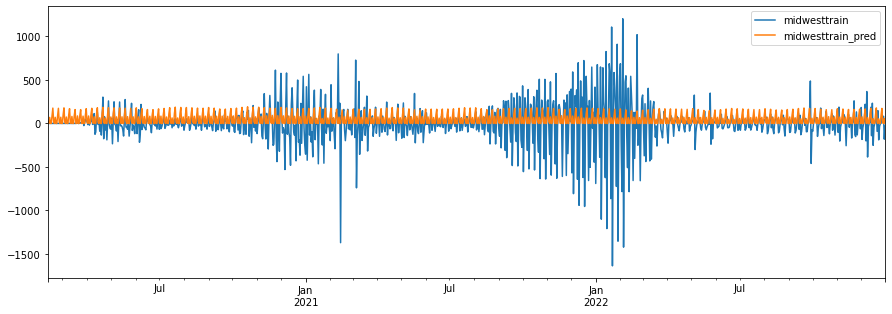

Training Set Metrics:
MAE: 131.7200639556332
MASE: 0.8318283320892829


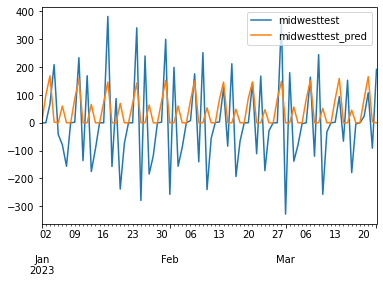

Testing Set Metrics:
MAE: 117.97105498109573
MASE: 0.8291995510383741


In [160]:
# CURRENT BEST
mmodel = prophet.Prophet(
    changepoint_prior_scale=0.006, # controls flexibility of trend
    seasonality_prior_scale=6.0, # controls strength of seasonality components
    yearly_seasonality=3,  
)
mmodel.add_seasonality(name='monthly', period=30.44, fourier_order=5)
mmodel.add_seasonality(name='weekly', period=7, fourier_order=3)

mmodel.fit(midwesttrain.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'}))

# train
midwesttrain_pred=mmodel.predict(midwesttrain.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'})).set_index('ds')
#clipping negative predictions
midwesttrain_pred = np.maximum(midwesttrain_pred, 0)
pd.concat([midwesttrain,midwesttrain_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['midwesttrain', 'midwesttrain_pred'])
plt.show()

# Calculate metrics

actual_train = midwesttrain['daily_deaths'].values
predicted_train = midwesttrain_pred['yhat'].values

mae_train = mean_absolute_error(actual_train, predicted_train)
mase_train = MASE(actual_train, predicted_train)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

# test
midwesttest_pred=mmodel.predict(midwesttest.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'})).set_index('ds')

#clipping negative predictions
midwesttest_pred = np.maximum(midwesttest_pred, 0)
pd.concat([midwesttest,midwesttest_pred['yhat']], axis=1).plot( )
plt.legend(['midwesttest', 'midwesttest_pred'])
plt.show()

# Calculate metrics

actual_test = midwesttest['daily_deaths'].values
predicted_test = midwesttest_pred['yhat'].values

mae_test = mean_absolute_error(actual_test, predicted_test)
mase_test = MASE(actual_test, predicted_test)
print("Testing Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

## south

INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


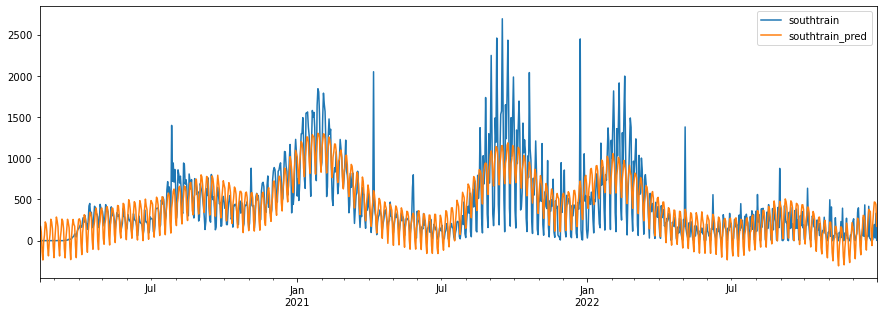

Training Set Metrics:
MAE: 172.44944919792368
MASE: 0.8155475434676542


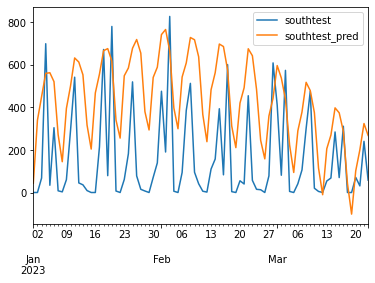

Testing Set Metrics:
MAE: 288.17227429625325
MASE: 0.8933399916347543


In [161]:
smodel = prophet.Prophet(
    changepoint_prior_scale=0.26, # controls flexibility of trend
    seasonality_prior_scale=6.0, # controls strength of seasonality components
    yearly_seasonality=3,  
)
smodel.add_seasonality(name='monthly', period=30.44, fourier_order=10)
smodel.add_seasonality(name='weekly', period=7, fourier_order=20)


smodel.fit(southtrain.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'}))

#train
southtrain_pred=smodel.predict(southtrain.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'})).set_index('ds')

pd.concat([southtrain,southtrain_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['southtrain', 'southtrain_pred'])
plt.show()

# Calculate metrics

actual_train = southtrain['daily_deaths'].values
predicted_train = southtrain_pred['yhat'].values

mae_train = mean_absolute_error(actual_train, predicted_train)
mase_train = MASE(actual_train, predicted_train)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

# test
southtest_pred=smodel.predict(southtest.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'})).set_index('ds')

pd.concat([southtest,southtest_pred['yhat']], axis=1).plot( )
plt.legend(['southtest', 'southtest_pred'])
plt.show()

# Calculate metrics

actual_test = southtest['daily_deaths'].values
predicted_test = southtest_pred['yhat'].values

mae_test = mean_absolute_error(actual_test, predicted_test)
mase_test = MASE(actual_test, predicted_test)
print("Testing Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

So i noticed something interesting with the Southtest_pred graph:
- it appears that the trends are accounted for well BUT the predictions seem almost to be shifted up vertically
- so in order to address this I shifted the train values down

INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


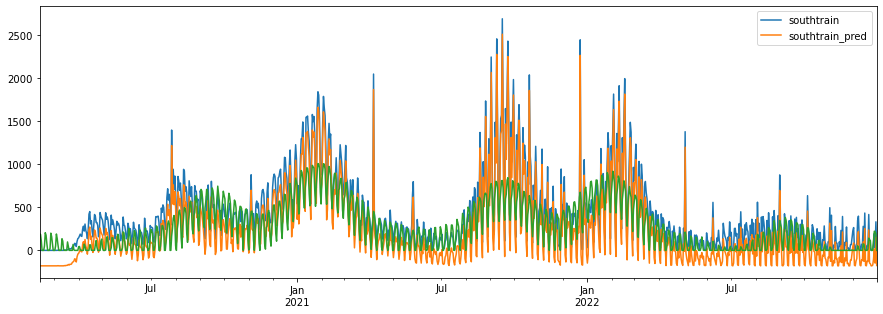

Training Set Metrics:
MAE: 197.0833677921142
MASE: 0.8899162993855364


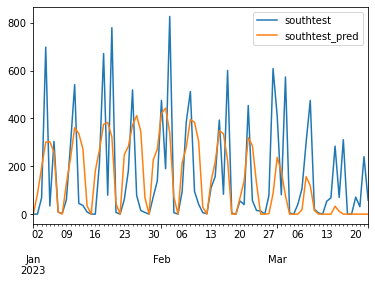

Testing Set Metrics:
MAE: 132.38862794515373
MASE: 0.8514215406759845


In [187]:
# adjusted

southtrain['adjusted_daily_deaths'] = southtrain['daily_deaths'] - 180

smodel = prophet.Prophet(
    changepoint_prior_scale=0.12, # controls flexibility of trend
    seasonality_prior_scale=6.0, # controls strength of seasonality components
    yearly_seasonality=3,  
)
smodel.add_seasonality(name='monthly', period=30.44, fourier_order=10)
smodel.add_seasonality(name='weekly', period=7, fourier_order=20)


smodel.fit(southtrain.reset_index().rename(columns={'date':'ds', 'adjusted_daily_deaths':'y'}))

#train
southtrain_pred=smodel.predict(southtrain.reset_index().rename(columns={'date':'ds', 'adjusted_daily_deaths':'y'})).set_index('ds')
#clipping negative
southtrain_pred = np.maximum(southtrain_pred, 0)
pd.concat([southtrain,southtrain_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['southtrain', 'southtrain_pred'])
plt.show()

# Calculate metrics

actual_train = southtrain['adjusted_daily_deaths'].values
predicted_train = southtrain_pred['yhat'].values

mae_train = mean_absolute_error(actual_train, predicted_train)
mase_train = MASE(actual_train, predicted_train)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

# test
southtest_pred=smodel.predict(southtest.reset_index().rename(columns={'date':'ds', 'adjusted_daily_deaths':'y'})).set_index('ds')
#clipping negative
southtest_pred = np.maximum(southtest_pred, 0)
pd.concat([southtest,southtest_pred['yhat']], axis=1).plot( )
plt.legend(['southtest', 'southtest_pred'])
plt.show()

# Calculate metrics

actual_test = southtest['daily_deaths'].values
predicted_test = southtest_pred['yhat'].values

mae_test = mean_absolute_error(actual_test, predicted_test)
mase_test = MASE(actual_test, predicted_test)
print("Testing Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

## west

INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


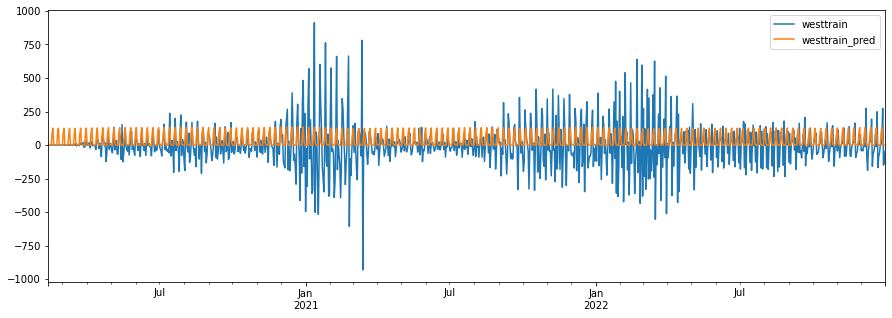

Training Set Metrics:
MAE: 96.00785251446541
MASE: 0.8673522679524177


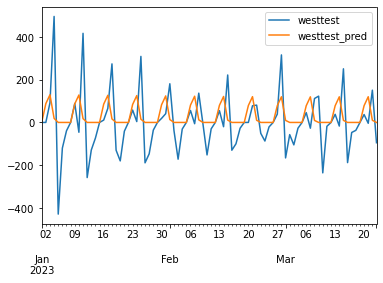

Testing Set Metrics:
MAE: 99.32082668863195
MASE: 0.8951229737094313


In [162]:
# CURRENT BEST
wmodel = prophet.Prophet(
    changepoint_prior_scale=0.21, # controls flexibility of trend
    seasonality_prior_scale=10.0, # controls strength of seasonality components
    yearly_seasonality=3,
)
#wmodel.add_seasonality(name='monthly', period=30.44, fourier_order=2)
wmodel.add_seasonality(name='weekly', period=7, fourier_order=2)

wmodel.fit(westtrain.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'}))

# train
westtrain_pred=wmodel.predict(westtrain.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'})).set_index('ds')
#clipping negative
westtrain_pred = np.maximum(westtrain_pred, 0)
pd.concat([westtrain,westtrain_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['westtrain', 'westtrain_pred'])
plt.show()

# Calculate metrics

actual_train = westtrain['daily_deaths'].values
predicted_train = westtrain_pred['yhat'].values

mae_train = mean_absolute_error(actual_train, predicted_train)
mase_train = MASE(actual_train, predicted_train)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

# test
westtest_pred=wmodel.predict(westtest.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'})).set_index('ds')
#clipping negative
westtest_pred = np.maximum(westtest_pred, 0)
pd.concat([westtest,westtest_pred['yhat']], axis=1).plot( )
plt.legend(['westtest', 'westtest_pred'])
plt.show()

# Calculate metrics

actual_test = westtest['daily_deaths'].values
predicted_test = westtest_pred['yhat'].values

mae_test = mean_absolute_error(actual_test, predicted_test)
mase_test = MASE(actual_test, predicted_test)
print("Testing Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

# combining forecast

Combined MAE (Testing Set): 252.8657845300593
Combined MASE (Testing Set): 0.9154074064401283
Combined MAE (Training Set): 526.6617264954831
Combined MASE (Training Set): 0.9720353527020787


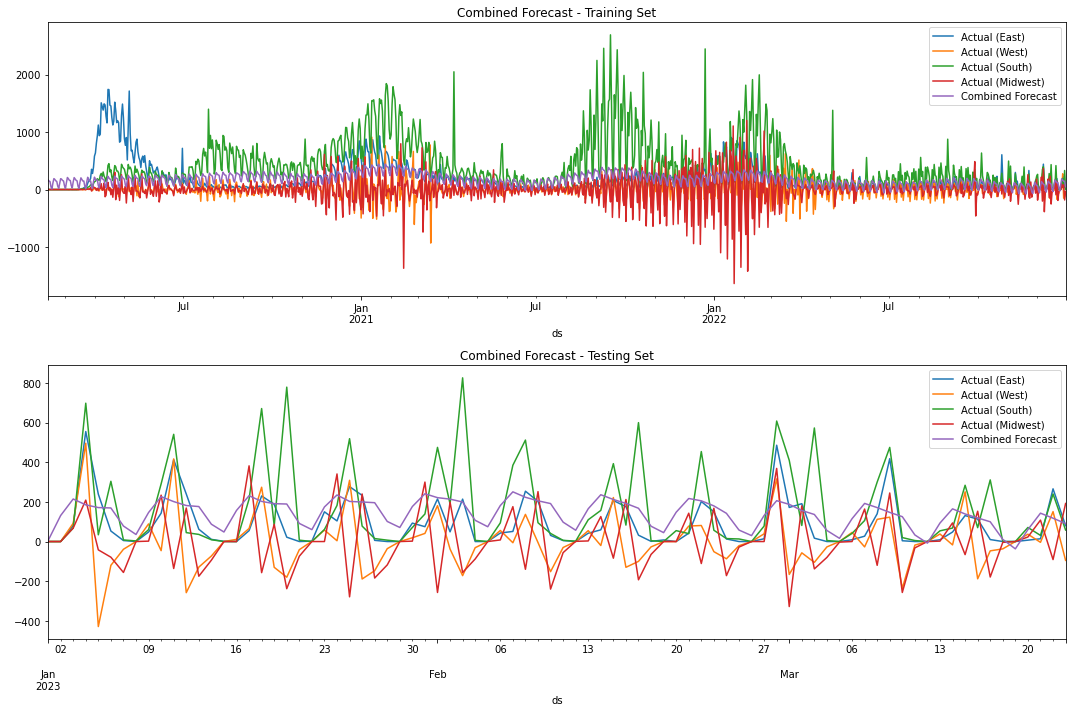

In [163]:
# Combine forecasts for the testing set
combined_forecast_test = (easttest_pred['yhat'] + westtest_pred['yhat'] + southtest_pred['yhat'] + midwesttest_pred['yhat']) / 4

# Combine actual values for the testing set
actual_values_combined_test = easttest['daily_deaths'].values + westtest['daily_deaths'].values + southtest['daily_deaths'].values + midwesttest['daily_deaths'].values

# Calculate metrics for the testing set
mae_combined_test = mean_absolute_error(actual_values_combined_test, combined_forecast_test.values)
print(f"Combined MAE (Testing Set): {mae_combined_test}")
mase_combined_test = MASE(actual_values_combined_test, combined_forecast_test.values)
print(f"Combined MASE (Testing Set): {mase_combined_test}")

# Combine forecasts for the training set
combined_forecast_train = (easttrain_pred['yhat'] + westtrain_pred['yhat'] + southtrain_pred['yhat'] + midwesttrain_pred['yhat']) / 4

# Combine actual values for the training set
actual_values_combined_train = easttrain['daily_deaths'].values + westtrain['daily_deaths'].values + southtrain['daily_deaths'].values + midwesttrain['daily_deaths'].values

# Calculate metrics for the training set
mae_combined_train = mean_absolute_error(actual_values_combined_train, combined_forecast_train.values)
print(f"Combined MAE (Training Set): {mae_combined_train}")
mase_combined_train = MASE(actual_values_combined_train, combined_forecast_train.values)
print(f"Combined MASE (Training Set): {mase_combined_train}")

# Combine actual values for plotting
actual_values_combined_train_df = pd.concat([easttrain['daily_deaths'], westtrain['daily_deaths'], southtrain['daily_deaths'], midwesttrain['daily_deaths']], axis=1)
actual_values_combined_train_df.columns = ['East', 'West', 'South', 'Midwest']

# Combine actual values for plotting
actual_values_combined_test_df = pd.concat([easttest['daily_deaths'], westtest['daily_deaths'], southtest['daily_deaths'], midwesttest['daily_deaths']], axis=1)
actual_values_combined_test_df.columns = ['East', 'West', 'South', 'Midwest']

# Plot the actual values and combined forecasts for both training and testing sets
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

# Training set plot
actual_values_combined_train_df.plot(ax=axes[0])
combined_forecast_train.plot(ax=axes[0], label='Combined Forecast')
axes[0].legend(['Actual (East)', 'Actual (West)', 'Actual (South)', 'Actual (Midwest)', 'Combined Forecast'])
axes[0].set_title('Combined Forecast - Training Set')

# Testing set plot
actual_values_combined_test_df.plot(ax=axes[1])
combined_forecast_test.plot(ax=axes[1], label='Combined Forecast')
axes[1].legend(['Actual (East)', 'Actual (West)', 'Actual (South)', 'Actual (Midwest)', 'Combined Forecast'])
axes[1].set_title('Combined Forecast - Testing Set')

plt.tight_layout()
plt.show()


after adjusting the southtrain

Combined MAE (Testing Set): 275.33077283216255
Combined MASE (Testing Set): 0.9553841369675309
Combined MAE (Training Set): 482.360747399095
Combined MASE (Training Set): 0.9632635465575812


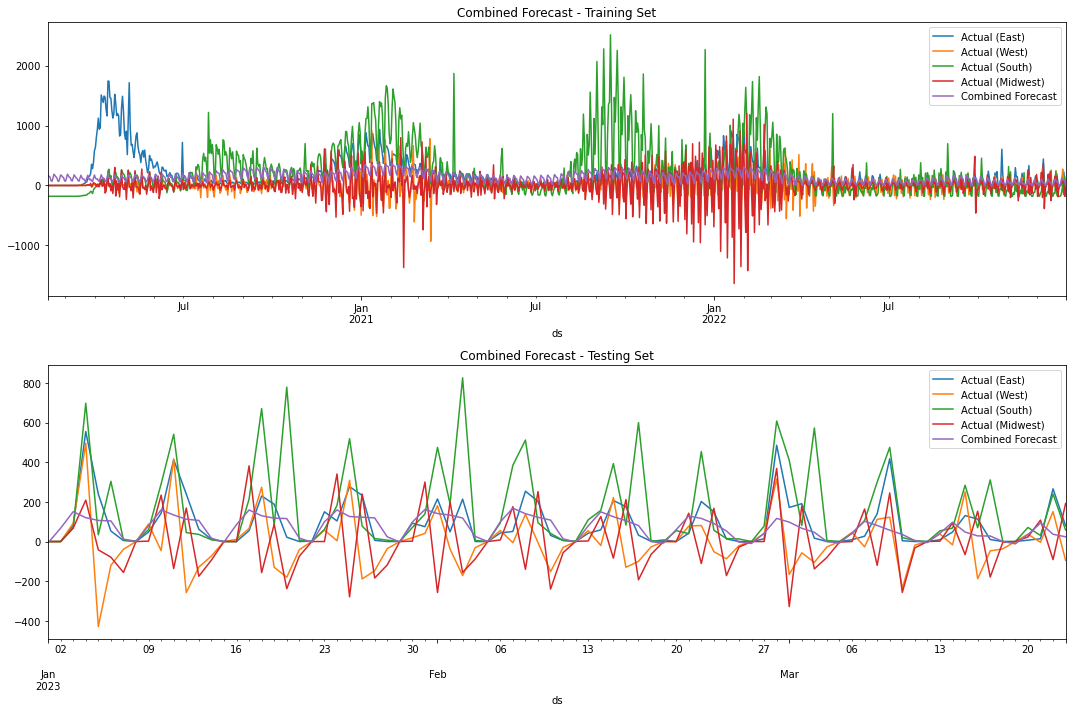

In [188]:
# Combine forecasts for the testing set
combined_forecast_test = (easttest_pred['yhat'] + westtest_pred['yhat'] + southtest_pred['yhat'] + midwesttest_pred['yhat']) / 4

# Combine actual values for the testing set
actual_values_combined_test = easttest['daily_deaths'].values + westtest['daily_deaths'].values + southtest['daily_deaths'].values + midwesttest['daily_deaths'].values

# Calculate metrics for the testing set
mae_combined_test = mean_absolute_error(actual_values_combined_test, combined_forecast_test.values)
print(f"Combined MAE (Testing Set): {mae_combined_test}")
mase_combined_test = MASE(actual_values_combined_test, combined_forecast_test.values)
print(f"Combined MASE (Testing Set): {mase_combined_test}")

# Combine forecasts for the training set
combined_forecast_train = (easttrain_pred['yhat'] + westtrain_pred['yhat'] + southtrain_pred['yhat'] + midwesttrain_pred['yhat']) / 4

# Combine actual values for the training set
actual_values_combined_train = easttrain['daily_deaths'].values + westtrain['daily_deaths'].values + southtrain['adjusted_daily_deaths'].values + midwesttrain['daily_deaths'].values

# Calculate metrics for the training set
mae_combined_train = mean_absolute_error(actual_values_combined_train, combined_forecast_train.values)
print(f"Combined MAE (Training Set): {mae_combined_train}")
mase_combined_train = MASE(actual_values_combined_train, combined_forecast_train.values)
print(f"Combined MASE (Training Set): {mase_combined_train}")

# Combine actual values for plotting
actual_values_combined_train_df = pd.concat([easttrain['daily_deaths'], westtrain['daily_deaths'], southtrain['adjusted_daily_deaths'], midwesttrain['daily_deaths']], axis=1)
actual_values_combined_train_df.columns = ['East', 'West', 'South', 'Midwest']

# Combine actual values for plotting
actual_values_combined_test_df = pd.concat([easttest['daily_deaths'], westtest['daily_deaths'], southtest['daily_deaths'], midwesttest['daily_deaths']], axis=1)
actual_values_combined_test_df.columns = ['East', 'West', 'South', 'Midwest']

# Plot the actual values and combined forecasts for both training and testing sets
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

# Training set plot
actual_values_combined_train_df.plot(ax=axes[0])
combined_forecast_train.plot(ax=axes[0], label='Combined Forecast')
axes[0].legend(['Actual (East)', 'Actual (West)', 'Actual (South)', 'Actual (Midwest)', 'Combined Forecast'])
axes[0].set_title('Combined Forecast - Training Set')

# Testing set plot
actual_values_combined_test_df.plot(ax=axes[1])
combined_forecast_test.plot(ax=axes[1], label='Combined Forecast')
axes[1].legend(['Actual (East)', 'Actual (West)', 'Actual (South)', 'Actual (Midwest)', 'Combined Forecast'])
axes[1].set_title('Combined Forecast - Testing Set')

plt.tight_layout()
plt.show()


# if not split by region

In [92]:
# Read each CSV file into a DataFrame
east_df = pd.read_csv('final data/east_daily.csv')
midwest_df = pd.read_csv('final data/midwest_stationary.csv')
south_df = pd.read_csv('final data/south_daily.csv')
west_df = pd.read_csv('final data/west_stationary.csv')

# Concatenate the DataFrames along the rows (axis=0)
combined_df = pd.concat([east_df, midwest_df, south_df, west_df], ignore_index=True)
combined_df.set_index('date', inplace=True)
combined_df.head()

,daily_deaths
date,
2020-02-12,0.0
2020-02-13,0.0
2020-02-14,0.0
2020-02-15,0.0
2020-02-16,0.0


In [93]:
all_regions_train = combined_df[combined_df.index < '2023-01-01']
all_regions_test = combined_df[combined_df.index >= '2023-01-01']
print(all_regions_train.shape, all_regions_test.shape)

(4216, 1) (328, 1)


In [ ]:
allmodel = prophet.Prophet(
    changepoint_prior_scale=0.04,  # Adjust parameters as needed
    seasonality_prior_scale=7.0,
    yearly_seasonality=False,
)
allmodel.add_seasonality(name='monthly', period=30.44, fourier_order=5)
allmodel.add_seasonality(name='weekly', period=7, fourier_order=3)

allmodel.fit(all_regions_train.reset_index().rename(columns={'date': 'ds', 'daily_deaths': 'y'}))

# train
alltrain_pred=allmodel.predict(all_regions_train.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'})).set_index('ds')
#clipping negative
alltrain_pred = np.maximum(alltrain_pred, 0)
pd.concat([all_regions_train,alltrain_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['alltrain', 'alltrain_pred'])
plt.show()

# Calculate metrics

actual_train = all_regions_train['daily_deaths'].values
predicted_train = alltrain_pred['yhat'].values

mae_train = mean_absolute_error(actual_train, predicted_train)
mase_train = MASE(actual_train, predicted_train)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

# test
alltest_pred=allmodel.predict(all_regions_test.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'})).set_index('ds')
#clipping negative
alltest_pred = np.maximum(alltest_pred, 0)
pd.concat([all_regions_test,alltest_pred['yhat']], axis=1).plot( )
plt.legend(['alltest', 'alltest_pred'])
plt.show()

# Calculate metrics

actual_test = all_regions_test['daily_deaths'].values
predicted_test = alltest_pred['yhat'].values

mae_test = mean_absolute_error(actual_test, predicted_test)
mase_test = MASE(actual_test, predicted_test)
print("Testing Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)